In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from Learn_AI.my_deeplearning_train import train_classification_model, evaluate_classification_model, EarlyStopping, ModelSaver,plot_learning_loss_and_acc_curves

# Define the transforms

### 划分验证集、测试集、训练集，并加入dataloader

In [2]:
# 从torchvision.datasets中加载FashionMNIST数据集
train_data = datasets.FashionMNIST(   #train_data很像一个生成器，逐步将数据加入
    root='../data',  # 数据存储路径
    train=True,   # 使用训练集
    download=True,  # 如果数据不存在则下载
    transform=ToTensor()  # 将图像转换为张量
)
# 计算训练集的均值和标准差
train_data_array = torch.stack([img for img, _ in train_data])  # 将训练集中的所有图像堆叠成一个大张量
mean = train_data_array.mean()  # 计算所有图像的平均值
std = train_data_array.std()    # 计算所有图像的标准差

train_data = datasets.FashionMNIST(  
    root='../data',  # 数据存储路径
    train=True,   # 使用训练集
    download=True,  # 如果数据不存在则下载
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])  # 将图像转换为张量并标准化
)


# 计算训练集和验证集的样本数
train_size = 55000
val_size =5000

# 使用random_split函数将数据集划分为训练集和验证集
train_dataset, val_dataset = random_split(
    train_data, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # 设置随机种子以确保可重复性
)




# 加载测试数据集
test_dataset = datasets.FashionMNIST(
    root='../data',  # 指定数据存储路径
    train=False,  # 使用测试集
    download=True,  # 如果数据不存在则下载
    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean,), (std,))])
)


# 设置批次大小
batch_size = 64

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,  # 训练数据集
    batch_size=batch_size,  # 每批次的样本数
    shuffle=True  # 随机打乱数据
)

val_loader = DataLoader(
    val_dataset,  # 验证数据集
    batch_size=batch_size,
    shuffle=False  # 验证集不需要打乱
)

test_loader = DataLoader(
    test_dataset,  # 测试数据集
    batch_size=batch_size,
    shuffle=False  # 测试集不需要打乱
)


In [3]:
# # 在测试集上评估模型
# test_loss, test_accuracy = evaluate_model(model, test_loader, device, criterion)

# print(f'\n测试集结果:')
# print(f'平均损失: {test_loss:.4f}')
# print(f'准确率: {test_accuracy:.2f}%')


### 搭建神经网络类

In [4]:
import torch
import torch.nn as nn
import torch.nn.init as init

class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=3):
        super().__init__()
        # 输入层: 784 (28*28) -> 100
        self.input_layer = nn.Linear(28*28, 100)
        
        # 创建layers_num个隐藏层，每个都是100->100
        self.hidden_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()           #还有nn.Sequential()方法
        for _ in range(layers_num):
            self.hidden_layers.append(nn.Linear(100, 100))
            self.batch_norms.append(nn.BatchNorm1d(100))
        
        # 输出层: 100 -> 10 (10个类别)
        self.output_layer = nn.Linear(100, 10)
        
        # 定义ReLU激活函数,用于在神经网络中引入非线性变换
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.02)
        
        # 使用Xavier初始化权重
        self._initialize_weights()
        
    def _initialize_weights(self):
        # # 初始化输入层权重
        # init.xavier_uniform_(self.input_layer.weight)  #第一层是展平不需要
        
        # 初始化所有隐藏层权重
        for layer in self.hidden_layers:
            init.xavier_uniform_(layer.weight)
            
        # 初始化输出层权重
        init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        # 将输入张量展平为一维向量
        # 将输入张量重塑为(batch_size, 784)的形状，其中784=28*28是输入图像的像素总数
        x = x.view(-1, 28 * 28)
        
        # 通过输入层
        x = self.input_layer(x)
        # x = self.relu(x)
        
        # 通过所有隐藏层
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.batch_norms[i](x)
            x = self.relu(x)
            x = self.dropout(x)
        
        # 通过输出层
        x = self.output_layer(x)
        
        # 返回神经网络的输出结果
        return x


### 设置损失函数和优化器，以及用cpu还是GPU

In [5]:
model=NeuralNetwork(layers_num=20)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 定义损失函数为交叉熵损失
# 定义损失函数为交叉熵损失
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数用于多分类问题:
                                 # 1. 它将模型输出的logits转换为概率分布(通过softmax)
                                 # 2. 计算预测概率分布与真实标签之间的交叉熵
                                 # 3. 自动处理数值稳定性问题
                                 # 4. 输出一个标量损失值,用于反向传播优化模型

# 定义优化器为，学习率设为0.001，model.parameters()表示模型中需要优化的参数
optimizer = torch.optim.SGD(model.parameters(), lr=0.002,momentum=0.9,nesterov=True,weight_decay=0.0001)#momentum意思：动量，表示在更新参数时，考虑之前的梯度信息，以加速收敛
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


In [6]:
# # 在测试集上评估模型
# test_loss, test_accuracy = evaluate_model(model, test_loader, device, criterion)

# print(f'\n测试集结果:')
# print(f'平均损失: {test_loss:.4f}')
# print(f'准确率: {test_accuracy:.2f}%')


### 计算模型的参数量

####  类里有call方法时，创建的对象可以（）有参数

In [7]:
def count_parameters(model):
    """计算模型的总参数量和每层参数量"""
    # 使用nn.Module的方法获取参数量
    total_params = 0
    
    # 遍历模型的所有命名参数
    for name, parameter in model.named_parameters():
        param_count = parameter.numel()
        total_params += param_count
        # 打印每层的参数名称、形状和参数量
        print(f'层: {name}',end=', ')
        print(f'参数量: {param_count:,}')
        # 如果是权重层，检查是否有对应的bias
        if 'weight' in name:
            bias_name = name.replace('weight', 'bias')
    
    return total_params

# 打印模型总参数量
total_parameters = count_parameters(model)
print(f'模型总参数量: {total_parameters:,}')


层: input_layer.weight, 参数量: 78,400
层: input_layer.bias, 参数量: 100
层: hidden_layers.0.weight, 参数量: 10,000
层: hidden_layers.0.bias, 参数量: 100
层: hidden_layers.1.weight, 参数量: 10,000
层: hidden_layers.1.bias, 参数量: 100
层: hidden_layers.2.weight, 参数量: 10,000
层: hidden_layers.2.bias, 参数量: 100
层: hidden_layers.3.weight, 参数量: 10,000
层: hidden_layers.3.bias, 参数量: 100
层: hidden_layers.4.weight, 参数量: 10,000
层: hidden_layers.4.bias, 参数量: 100
层: hidden_layers.5.weight, 参数量: 10,000
层: hidden_layers.5.bias, 参数量: 100
层: hidden_layers.6.weight, 参数量: 10,000
层: hidden_layers.6.bias, 参数量: 100
层: hidden_layers.7.weight, 参数量: 10,000
层: hidden_layers.7.bias, 参数量: 100
层: hidden_layers.8.weight, 参数量: 10,000
层: hidden_layers.8.bias, 参数量: 100
层: hidden_layers.9.weight, 参数量: 10,000
层: hidden_layers.9.bias, 参数量: 100
层: hidden_layers.10.weight, 参数量: 10,000
层: hidden_layers.10.bias, 参数量: 100
层: hidden_layers.11.weight, 参数量: 10,000
层: hidden_layers.11.bias, 参数量: 100
层: hidden_layers.12.weight, 参数量: 10,000
层: hidden_layer

In [8]:
early_stopping=EarlyStopping(patience=10, delta=0.01) 
model_saver=ModelSaver(save_best_only=True)
model_train, history = train_classification_model(model, train_loader, val_loader, criterion, optimizer, device,epochs=100,early_stopping=early_stopping,model_saver=model_saver)

训练开始，共43000步


  0%|          | 0/43000 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 88.9000
早停: 在39500 步


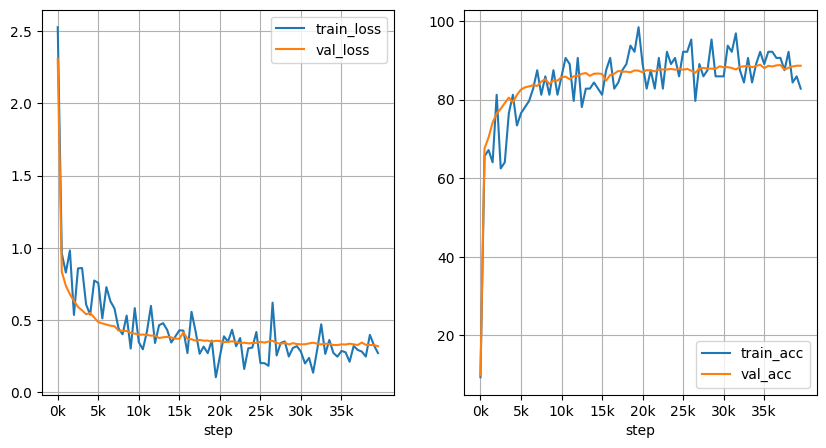

In [9]:
# 调用函数绘制学习曲线
his=history.copy()
plot_learning_loss_and_acc_curves(his,sample_step=500)

In [10]:
# 在测试集上评估模型
test_accuracy,test_loss  = evaluate_classification_model(model, test_loader, device, criterion)

print(f'\n测试集结果:')
print(f'平均损失: {test_loss:.4f}')
print(f'准确率: {test_accuracy:.2f}%')



测试集结果:
平均损失: 0.3291
准确率: 88.27%
